# Linear Regression: Baseline Done Right

This notebook demonstrates a **professional ML workflow** for regression:
- Proper train/val/test splits
- Meaningful baselines
- Feature scaling when needed
- Multiple error metrics
- Residual analysis

**Goal:** Establish a clear baseline and understand model errors.

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Load your dataset here
# Example: df = pd.read_csv('data/housing.csv')
# For demo, we'll use a synthetic dataset

np.random.seed(42)
n_samples = 1000
X = np.random.randn(n_samples, 3)
y = 2 * X[:, 0] + 1.5 * X[:, 1] - 0.5 * X[:, 2] + np.random.randn(n_samples) * 0.5

df = pd.DataFrame(X, columns=['feature_1', 'feature_2', 'feature_3'])
df['target'] = y

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1000, 4)


,feature_1,feature_2,feature_3,target
0,0.496714,-0.138264,0.647689,-0.491716
1,1.523030,-0.234153,-0.234137,2.381706
2,1.579213,0.767435,-0.469474,4.337512
3,0.542560,-0.463418,-0.465730,1.566702
4,0.241962,-1.913280,-1.724918,-1.245260


## 2. Train/Val/Test Split

In [3]:
# Split features and target
X = df.drop('target', axis=1)
y = df['target']

# First split: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: train vs val (75/25 of remaining = 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Train: 600 samples
Val: 200 samples
Test: 200 samples


## 3. Baseline: Mean Predictor

In [4]:
# Baseline: always predict the mean of training target
baseline_pred = np.full_like(y_val, y_train.mean())

baseline_mae = mean_absolute_error(y_val, baseline_pred)
baseline_mse = mean_squared_error(y_val, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)

print(f"Baseline (mean predictor):")
print(f"  MAE:  {baseline_mae:.4f}")
print(f"  MSE:  {baseline_mse:.4f}")
print(f"  RMSE: {baseline_rmse:.4f}")

Baseline (mean predictor):
  MAE:  1.8259
  MSE:  5.4333
  RMSE: 2.3309


## 4. Feature Scaling (When Needed)

In [5]:
# Check if scaling is needed
print("Feature statistics:")
print(X_train.describe())

# For linear regression, scaling helps with interpretation and sometimes convergence
# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nAfter scaling:")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).describe())

Feature statistics:
        feature_1   feature_2   feature_3
count  600.000000  600.000000  600.000000
mean     0.033968   -0.024907    0.015812
std      0.964250    1.013997    0.999050
min     -2.940389   -3.241267   -3.019512
25%     -0.612024   -0.714377   -0.651464
50%      0.019719   -0.017285    0.014290
75%      0.671038    0.660915    0.670695
max      3.926238    3.193108    3.852731

After scaling:
          feature_1     feature_2     feature_3
count  6.000000e+02  6.000000e+02  6.000000e+02
mean   1.628327e-17  5.329071e-17  2.368476e-17
std    1.000834e+00  1.000834e+00  1.000834e+00
min   -3.087207e+00 -3.174610e+00 -3.040745e+00
25%   -6.705020e-01 -6.805198e-01 -6.684674e-01
50%   -1.479014e-02  7.523019e-03 -1.524256e-03
75%    6.612404e-01  6.769201e-01  6.560531e-01
max    4.039946e+00  3.176243e+00  3.843772e+00


## 5. Linear Regression Model

In [6]:
# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)

# Metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("Linear Regression Results:")
print(f"\nTraining:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"\nValidation:")
print(f"  MAE:  {val_mae:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"\nImprovement over baseline:")
print(f"  MAE reduction:  {(baseline_mae - val_mae) / baseline_mae * 100:.1f}%")
print(f"  RMSE reduction: {(baseline_rmse - val_rmse) / baseline_rmse * 100:.1f}%")

Linear Regression Results:

Training:
  MAE:  0.4237
  RMSE: 0.5241

Validation:
  MAE:  0.3949
  RMSE: 0.4829

Improvement over baseline:
  MAE reduction:  78.4%
  RMSE reduction: 79.3%


## 6. Model Interpretation

In [7]:
# Feature coefficients (on scaled features)
coefficients = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_,
    'abs_coefficient': np.abs(model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("Feature Coefficients:")
print(coefficients)
print(f"\nIntercept: {model.intercept_:.4f}")

Feature Coefficients:
     feature  coefficient  abs_coefficient
0  feature_1     1.935657         1.935657
1  feature_2     1.486106         1.486106
2  feature_3    -0.515920         0.515920

Intercept: 0.0097


## 7. Residual Analysis

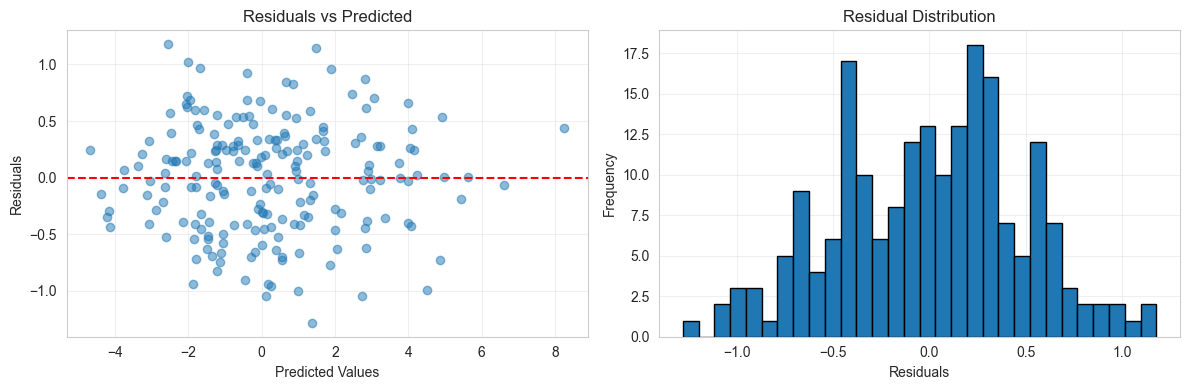

Residual Statistics:
  Mean: -0.001378 (should be ~0)
  Std:  0.4841
  Min:  -1.2813
  Max:  1.1783


In [8]:
# Calculate residuals
residuals = y_val - y_val_pred

# Plot 1: Residuals vs Predicted
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)

# Plot 2: Residual distribution
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Residual Statistics:")
print(f"  Mean: {residuals.mean():.6f} (should be ~0)")
print(f"  Std:  {residuals.std():.4f}")
print(f"  Min:  {residuals.min():.4f}")
print(f"  Max:  {residuals.max():.4f}")

## 8. Final Test Evaluation

In [9]:
# Final evaluation on test set (only once!)
y_test_pred = model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Final Test Results:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"\nComparison:")
print(f"  Validation RMSE: {val_rmse:.4f}")
print(f"  Test RMSE:       {test_rmse:.4f}")
print(f"  Difference:      {abs(test_rmse - val_rmse):.4f}")

Final Test Results:
  MAE:  0.4044
  RMSE: 0.5091

Comparison:
  Validation RMSE: 0.4829
  Test RMSE:       0.5091
  Difference:      0.0262


## 9. Key Takeaways

**What we learned:**
- Always establish a baseline first
- Proper data splits prevent overfitting
- Scaling matters for interpretation
- Multiple metrics give different perspectives
- Residual analysis reveals model assumptions

**Next steps:**
- Try feature engineering
- Experiment with regularization (Ridge/Lasso)
- Consider polynomial features if needed